# Analysing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The aim of this project was to analyse A/B test results run by an e-commerce website to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. A/B tests are commonly used to test changes on a web page by running an experiment where a control group sees the old version and an experiment group see the new version. The results are then analysed and used to judge whether one version is more effective than the other.

This report will demonstrate the overall process used to analyse the results with the accompanying Python code and justification for decisions made will be provided throughout. 

<a id='probability'></a>
#### Part I - Probability

The first step in this process was to import libraries and gain an understanding of the dataset.

In [37]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Seed set by Udacity to assure the same answers on quizzes provided in the Udacity Classroom
random.seed(42)

`1.` In this initial step the `ab_data.csv` data was read, stored in `df`, and the top few rows were investigated.

In [38]:
# read in the dataset and take look at top few rows
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Next the below cell was used to find the number of rows in the dataset.

In [39]:
# find number of rows in dataset
df.shape
# number of rows is 294478

(294478, 5)

From above, it is clear that the number of rows in the dataset is 294478.

c. Then the number of unique users in the dataset was found.

In [40]:
# get the number of unique users
df.nunique()
# number of unique users is 290584

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

From the above code it was found that the number of unique users in the dataset was 290584. The size of the control group and treatment group were then investigated to ensure they were approximately evenly divided.

In [41]:
#find how the two groups are split
df.groupby('group').nunique()

,user_id,timestamp,group,landing_page,converted
group,,,,,
control,146195,147202,1,2,2
treatment,146284,147276,1,2,2


d. The proportion of users converted was found next. In this case converted means the number of users who decided to pay for the company's product.

In [42]:
# proportion of users converted. Converted means the number of users who decided to pay for the company's product
df.converted.mean()
#proportion converted = 12%

0.11965919355605512

The proportion of users converted was found to be 12%.

e. The number of times the `new_page` and `treatment` don't line up was then investigated. In A/B testing, the control group should see the old page while the experiment group should see the new version. Therefore the above code identifies the cases where the group type is mismatched to the landing page. 

In [43]:
# Find mismatched groups and landing pages.
df[((df['landing_page'] == 'new_page') & (df['group'] != 'treatment')) | ((df['landing_page'] == 'old_page') & (df['group'] != 'control'))]  

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


It is clear from the code above that there are 3893 instances where the group and landing page don't match up correctly.

f. The final step in this subsection was to investigate if any of the rows had missing values.

In [44]:
#checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


From the above, it is evident that there are no missing values in any of the rows in this dataset. 

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore, in order to handles these rows where the `landing_page` and `group` columns don't match I will remove these rows.

Therefore a new dataset which removes these rows is created and stored in `df2`.

In [45]:
# create new dataset df2 where instances where landing page is new_page and the group isn't treatment or landing page is old_page and the group isn't control are dropped 
df2 = df.drop(df[((df['landing_page'] == 'new_page') & (df['group'] != 'treatment')) | ((df['landing_page'] == 'old_page') & (df['group'] != 'control'))].index)

In [46]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [47]:
# Double check the first few rows
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [48]:
# check the number of rows is 294478 - 3893 = 290585
df2.shape

(290585, 5)

The messy data was handled by removing mismatched rows and the number of rows was been checked and was as expected since 294478 - 3893 = 290585. Further exploration of the new dataset was then performed as illustrated below. 

`3.` The new dataset `df2` was explored by answering the questions below and these were checked against the answers in quiz 3 of the classroom to ensure the updated dataframe was as expected.

a. How many unique **user_id**s are in **df2**?

In [49]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

The number of unique user_ids is 290584 and there is one duplicated.

b. There is one **user_id** repeated in **df2**.  What is it?

In [50]:
# Double checking there is exactly one user_id repeated
sum(df2.user_id.duplicated())

1

In [51]:
# Pulling the user_id that is repeated
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [52]:
# checking the other instance when the user_id visited the site
df2.loc[df2.user_id.duplicated(keep = 'last')]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


The non-unique user id in df2 is 773192.

c. What is the row information for the repeat **user_id**? 

The row information above shows that the user_id was 773192 and that this has a timestamp of 2017-01-14 02:55:59.590927 from one visit and 2017-01-09 05:37:58.781806 from another visit, the user_id was in the treatment group, saw the new landing page and wasn't converted.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [53]:
# dropping the row by index 
df2.drop([2893], inplace = True)

In [54]:
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [55]:
#double checking the drop worked as expected. There should now be no duplicated user_ids
sum(df2.user_id.duplicated())

0

In [56]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Next **df2** was used in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [57]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [58]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [59]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [60]:
df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

When considering results from the answers from a. through to d. above, it is evident that there is in fact not sufficient evidence to say that the new treatment page leads to more conversions. 

From above it is shown that:
 - the probability of converting regardless of page is 0.1196
 - given an individual was in the control group the probability of converting was 0.1204
 - given an individual was in the treatment group the probability of converting was 0.1188
 - the probability of receiving a new page is 0.5001
 
It can be seen from above that the users were approximately equally as likely to receive a new page as an old page therefore the test seems fair. The probability of an individual from the treatment group converting is actually less than if they were from the control group, by approximately 0.16%, therefore when considering results from above there is not sufficient evidence to say that the new treatment page leads to more conversions. The next part of the report will investigate further.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, it would be technically possible to run a hypothesis test continuously as each observation was observed. However, then the hard question would be when to stop; as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another? These questions are the difficult parts associated with A/B tests in general.

The duration of the experiment was found below to gain a better understanding of the data.

In [61]:
df.timestamp.max(), df.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

From above, it is evident that the duration of the experiment lasted 22 days. This is important to note as it seems like an long enough duration and that the experiment has been seen by enough users (290584).

`1.` The metric of interest is the conversion rates for the old and new pages which is denoted by $p_{old}$ and $p_{new}$ respectively. Conversion rates are defined as the number of conversions divided by the number of views. Now the metric is clearly defined it is possible to set up the hypotheses. 

It is assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, therefore the null and alternative hypotheses are stated below in notation. In words, the null hypothesis states that the new page design has a conversion rate that is less than or equal to that of our old page design. The alternative hypothesis is that the new page design has a higher conversion rate than the old page design. 

$$H_0: p_{new} - p_{old}  =< 0 $$
$$H_1: p_{new} - p_{old}  > 0$$

`2.` It is assumed that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it is assumed they are equal to the **converted** rate in **ab_data.csv** regardless of the page. Additionally, a sample size for each page equal to the ones in **ab_data.csv** is used. The sampling distribution is performed for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

Assuming that under the null hypothesis $p_{new}$ and $p_{old}$ are equal and also equal to the converted rate regardless of page the convert rate is as below:

In [62]:
# conversion rate 
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? 

As stated above this is equal to the convert rate for $p_{new}$

In [63]:
#conversion rate
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [64]:
# number of rows in dataset for treatment group 
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [65]:
# number of rows in dataset for control group
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

In [66]:
# double check n_new and n_old
df2.groupby('group').nunique()

,user_id,timestamp,group,landing_page,converted
group,,,,,
control,145274,145274,1,1,2
treatment,145310,145310,1,1,2


In [67]:
# p_new - p_old under the null
p_diff = p_new - p_old
p_diff #this is 0 as expected due to our aforementioned assumptions

0.0

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [68]:
# simulate using np.random.binomial 
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page1 = new_page_converted.mean()
new_page1

0.11924850320005506

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [69]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page1 = old_page_converted.mean()
old_page1

0.11901647920481298

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [70]:
obs_diff = new_page1 - old_page1
obs_diff

0.00023202399524208106

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [71]:
# simulate 10,000 for difference in convert rates and store in np array
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    mean_newpage = new_page_converted.mean()
    mean_oldpage = old_page_converted.mean()
    p_diffs.append(mean_newpage - mean_oldpage)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

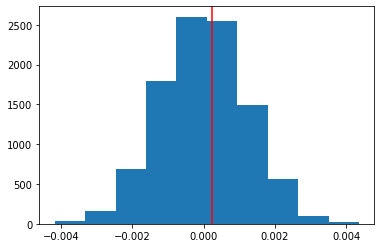

In [72]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

Since our observed statistic falls within the bulk of the distribution it is likely the statistic is from the null. Let's calculate the p-value.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [73]:
#compute the p-value
obs_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
p_diffs=np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9069

The p-value was calculated above. The p-value is the probability of observing our statistic if the null hypothesis is true. Large p_values suggest that we shouldn't move away from the null hypothesis. In this case we have obtained a large p-value and our threshold for type 1 errors is 0.05 which is significantly smaller than our p-value, thus this indicates we shouldn't move away from the null therefore based on the data we fail to reject the null hypothesis. 

l. It is also possible to used a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. The below calculates the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [74]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now the `stats.proportions_ztest` was used to compute the test statistic and p-value

In [75]:
from statsmodels.stats.proportion import proportions_ztest
count = [convert_new, convert_old]
nobs = [n_new, n_old]

z_score, p_value = proportions_ztest(count, nobs, alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. It is vital to consider what the z-score and p-value computed above mean for the conversion rates of the old and new pages, and to compare these to the findings from parts **j** and **k** of this report.

The z-score gives an indication of how many standard deviations an element is from the mean (definition from stattrek.com). Since the z-score here is -1.31 and our p-value is in agreement with part j with a value of approximately ~ 0.90 which is again larger than our alpha of 0.05, this indicates that these findings are in agreement with the findings from parts j and k. This means that we fail to reject the null hypothesis due to lack of evidence suggesting the alternative hypothesis is true.  

<a id='regression'></a>
### Part III - Logistic regression approach

`1.` In this final part, logistic regression will be performed to achieve a similar result from previous A/B test. <br><br>


Since each row in our dataset is either a conversion or no conversion it is evident that logistic regression should be used.

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to understand if there is a significant difference in conversion based on which page a customer receives. 

The first step is to create a column for the intercept, and create a dummy variable column for which page each user received.  An **intercept** column was added and set equal to 1 and then an **ab_page** column was created, which is 1 when an individual receives the **treatment** and 0 if they receive the **control**.

In [76]:
# creating columns using dummy variables
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [77]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [78]:
# it is obvious that new_page and old_page are superfluous and can be dropped here 
df2 = df2.drop(['new_page', 'old_page'], axis =1) #not required since ab_page contains this information but was a good check

In [79]:
# check that dropping new_page and old_page columns actually worked
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Next **statsmodels** was used to import the logistic regression model. The model was instantiated, and fit using the two columns created in part **b.** to predict whether or not an individual converts.

In [80]:
#fit model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:06:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. A summary of the model is provided.

In [81]:
# exponentiate each of the coefficients
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [82]:
# computing the reciprocal
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

It is evident from the results above that conversion is 1.02 times less likely to occur when the landing page is a new page holding all else constant. 

e. The p-value associated with the ab_page and found using logistic regression is 0.190 as shown above in the summary, it is clear that this is not statistically significant when comparing this to our alpha, Type I error threshold. Furthermore it is important to note that the p-value associated with **ab_page** differs from the value found in **Part II**. This is because of the differences in null and alternative hypotheses associated with the logistic regression model differ to those in Part II. In Part II we had a one-tailed test where the hypotheses were as follows:

$$H_0: p_{new} - p_{old}  =< 0 $$
$$H_1: p_{new} - p_{old}  > 0$$

However, in Logistic Regression the null hypothesis states that the estimate of the parameter is equal to 0 and the alternative is that the parameter is not equal to 0, and this was a two-tailed test therefore our p-values differ. Source [https://knowledge.udacity.com/questions/32860] is cited in Resources.

f. Other factors might influence whether or not an individual converts. Some advantages and disadvantages are discussed below.

It is beneficial to add other factors to the regression model as higher order terms at times as they can allow a better prediction of response, however this can make interpreting the results of the data more complex and also affect the interpretation of lower order terms.  


Additionally, there are also disadvantages such as multicollinearity where the explanatory variables are correlated with one another and which leads to inaccurate and misleading results. 


Furthermore, it is important to consider factors which can produce bias results such as change aversion and novelty effect. Change aversion is when existing users may give an unfair advantage to the old version because they are unhappy with change and novelty effect is the opposite scenario where existing users may give an unfair advantage to the new version because they're drawn to change. 

g. Along with testing if the conversion rate changes for different pages, an effect based on which country a user lives in was added. 

In [83]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


An inner join had to be performed to join the countries dataset with df2 to create a new dataset named `df_new`

In [84]:
# perform inner join on countries dataset and df2 on user_id
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [85]:
# check that the join worked as expected
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [86]:
# check which countries are in the dataset
countries_df.groupby('country').nunique()

,user_id,country
country,,
CA,14499,1
UK,72466,1
US,203619,1


In [87]:
### Create the necessary dummy variables
df_new ['intercept'] = 1
df_new [['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [88]:
#check dummy variables worked as desired
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [89]:
#perform logistic regression using US as a baseline
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:06:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [90]:
np.exp(results2.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [91]:
1/np.exp(results2.params)

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

From the results of the logistic regression it is clear that the country in fact does not have a significant impact on conversion, with none of the p_values being less than our Type 1 error, alpha, of 0.05. However, interestingly it is evident that users in the US are 1.04 times more likely to convert than users in Canada, holding all other variables constant. Additionally, users in the UK are 1.01 times more likely to convert than those in the US, holding all other variables constant. 

h. Now that individual factors of country and page on conversion have been considered, it is of interest to look at an interaction between page and country to see if there significant effects on conversion. Therefore, the necessary additional columns were created as below and the new model was fitted as below.

In [92]:
# creating new variables to look at interaction between page and country
df_new['ab_page_CA'] = df_new['ab_page']*df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page']*df_new['UK']

In [93]:
# checking new columns worked
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_page_CA,ab_page_UK
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [94]:
### Fit Logistic Regression Model And Obtain the Results
log_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'ab_page_CA', 'ab_page_UK']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               3.351e-05
Time:                        14:06:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0183      0.013     -1.449      0.147      -0.043       0.006
ab_page_CA    -0.0644      0.038     -1.679      0.093      -0.140       0.011
ab_page_UK     0.0257      0.019      1.363      0.173      -0.011       0.063
==============================================================================
"""

In [95]:
np.exp(results3.params)

intercept     0.136863
ab_page       0.981901
ab_page_CA    0.937618
ab_page_UK    1.025986
dtype: float64

In [96]:
1/np.exp(results3.params)

intercept     7.306593
ab_page       1.018432
ab_page_CA    1.066532
ab_page_UK    0.974672
dtype: float64

It is important to note that a new interaction term has been added into the regression model therefore the lower order term `ab_page` has also been added. From these results it is evident that interaction between page and country has no significant effects on conversion since none of the p-values are greater than 0.05. 

<a id='conclusions'></a>
## Conclusions

Based on the evidence gathered we fail to reject the initial null hypothesis therefore the new page should not be implemented. 

## Resources

Udacity Classroom lessons were used to complete this project, as well as the links listed below.

https://support.google.com/google-ads/answer/2684489?hl=en-GB#:~:text=Conversion%20rates%20are%20calculated%20by,50%20%C3%B7%201%2C000%20%3D%205%25.
https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html    
https://towardsdatascience.com/demystifying-hypothesis-testing-with-simple-python-examples-4997ad3c5294    
https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html    
https://stattrek.com/statistics/dictionary.aspx?definition=z-score    
https://www.simplypsychology.org/z-score.html    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html    
https://knowledge.udacity.com/questions/227837    
https://knowledge.udacity.com/questions/32860    
https://knowledge.udacity.com/questions/38871